In [1]:
!pip install plyfile
!pip install open3d

In [2]:
!pip install ipympl
%matplotlib widget


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
from pathlib import Path
import tkinter as tk
import os
import random
from plyfile import PlyData, PlyElement
import open3d as o3d
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# GOOSE Dataset

In [4]:
import numpy as np
import os
from pathlib import Path
from typing import List, Tuple
from tqdm import tqdm

def load_bin_file(bin_path: str, num_points: int = 4098) -> Tuple[np.ndarray, np.ndarray]:
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]
    if points.shape[0] > num_points:
        indices = np.random.choice(points.shape[0], num_points, replace=False)
        return points[indices], indices
    elif points.shape[0] < num_points:
        pad = np.zeros((num_points - points.shape[0], 3), dtype=np.float32)
        return np.vstack((points, pad)), np.arange(points.shape[0])  # No padding en índices
    return points, np.arange(num_points)

# GOOSE Categories mejoradas
category_mapping = {
    0: [43, 38, 58, 29, 41, 42, 44, 39, 55], # Construction
    1: [4, 45, 6, 40, 60, 61, 33, 32, 14], # Object
    2: [7, 22, 9, 26, 11, 21], # Road
    3: [48, 47, 1, 19, 46, 10, 25], # Sign
    4: [23, 3, 24, 31, 2], # Terrain  
    5: [51, 50, 5, 18], # Drivable Vegetation
    6: [28, 27, 62, 52, 16, 30, 59, 17], # Non Drivable Vegetation
    7: [13, 15, 12, 36, 57, 49, 20, 35, 37, 34, 63], # Vehicle
    8: [8, 56, 0, 53, 54], # Void
}

# Reverse mapping for fast lookup
label_to_category = {label: cat for cat, labels in category_mapping.items() for label in labels}

def map_labels(labels: np.ndarray) -> np.ndarray:
    """
    Mapea etiquetas al sistema de categorías definido en category_mapping.
    """
    return np.array([label_to_category.get(label, 8) for label in labels], dtype=np.uint8)

def load_label_file(label_path: str, indices: np.ndarray, num_points: int = 16384) -> np.ndarray:
    labels = np.fromfile(label_path, dtype=np.uint32) & 0xFFFF
    if labels.shape[0] > num_points:
        labels = labels[indices]  # Usar los mismos índices de los puntos
    elif labels.shape[0] < num_points:
        pad = np.full(num_points - labels.shape[0], 8, dtype=np.uint16)
        labels = np.hstack((labels, pad))
    return map_labels(labels)

def load_dataset(bin_files: List[str], label_files: List[str], num_points: int = 16384) -> Tuple[np.ndarray, np.ndarray]:
    x_data, y_data = [], []
    
    for bin_f, label_f in tqdm(zip(bin_files, label_files), total=len(bin_files), desc="Cargando datos"):
        points, indices = load_bin_file(bin_f, num_points)
        labels = load_label_file(label_f, indices, num_points)
        x_data.append(points)
        y_data.append(labels)
    
    return np.array(x_data, dtype=np.float32), np.array(y_data, dtype=np.uint8)

def get_file_paths(data_dir: str) -> List[str]:
    """
    Obtiene lista de archivos en un directorio.
    """
    return sorted([str(f) for f in Path(data_dir).glob("*.*")])

def load_all_data(x_train_dir: str, y_train_dir: str, x_val_dir: str, y_val_dir: str) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Carga todos los datos de entrenamiento y validación con barra de progreso en una sola línea por conjunto de datos.
    """
    x_train_files = get_file_paths(x_train_dir)
    y_train_files = get_file_paths(y_train_dir)
    x_val_files = get_file_paths(x_val_dir)
    y_val_files = get_file_paths(y_val_dir)
    
    assert len(x_train_files) == len(y_train_files), "Número de archivos x_train y y_train no coincide."
    assert len(x_val_files) == len(y_val_files), "Número de archivos x_val y y_val no coincide."
    
    print("Cargando datos de entrenamiento...")
    x_train, y_train = load_dataset(x_train_files, y_train_files)
    
    print("Cargando datos de validación...")
    x_val, y_val = load_dataset(x_val_files, y_val_files)
    
    return x_train, y_train, x_val, y_val

In [6]:
x_train_path = "/kaggle/input/goose-lidar/Goose/goose_3d_train/lidar/train"
y_train_path = "/kaggle/input/goose-lidar/Goose/goose_3d_train/labels/train"
x_val_path = "/kaggle/input/goose-lidar/Goose/goose_3d_val/lidar/val"
y_val_path = "/kaggle/input/goose-lidar/Goose/goose_3d_val/labels/val"

x_train, y_train, x_val, y_val = load_all_data(x_train_path, y_train_path, x_val_path, y_val_path)

Cargando datos de entrenamiento...


Cargando datos: 100%|██████████| 7719/7719 [07:30<00:00, 17.13it/s]


Cargando datos de validación...


Cargando datos: 100%|██████████| 961/961 [01:06<00:00, 14.50it/s]


In [8]:
indices_permutados_train = np.random.permutation(x_train.shape[0])
indices_permutados_val = np.random.permutation(x_val.shape[0])

x_train_shuffle = x_train[indices_permutados_train]
y_train_shuffle = y_train[indices_permutados_train]
x_val_shuffle = x_val[indices_permutados_val]
y_val_shuffle = y_val[indices_permutados_val]

In [11]:
y_train_shuffle

array([[6, 5, 5, ..., 6, 5, 6],
       [5, 6, 5, ..., 5, 5, 5],
       [6, 5, 0, ..., 5, 0, 5],
       ...,
       [6, 4, 6, ..., 6, 6, 6],
       [6, 1, 6, ..., 0, 7, 6],
       [6, 6, 6, ..., 6, 6, 6]], dtype=uint8)

In [13]:
import plotly.graph_objects as go
import numpy as np

def plot_3D(xyz, labels):
    """
    Visualiza una nube de puntos en 3D con Plotly.
    - xyz: (num_points, 3) array con coordenadas (X, Y, Z).
    - labels: (num_points,) array con etiquetas semánticas.
    """

    # Definir 9 colores predefinidos en formato RGB
    predefined_colors = [
        "rgb(255, 0, 0)",    # Rojo
        "rgb(0, 255, 0)",    # Verde
        "rgb(0, 0, 255)",    # Azul
        "rgb(255, 255, 0)",  # Amarillo
        "rgb(255, 165, 0)",  # Naranja
        "rgb(128, 0, 128)",  # Púrpura
        "rgb(0, 255, 255)",  # Cian
        "rgb(255, 192, 203)",# Rosa
        "rgb(128, 128, 128)" # Gris
    ]

    # Asignar colores según la etiqueta (se asume que las etiquetas van de 0 a 8)
    point_colors = [predefined_colors[label % len(predefined_colors)] for label in labels]

    # Crear la figura 3D en Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=xyz[:, 0], y=xyz[:, 1], z=xyz[:, 2],  # Coordenadas X, Y, Z
        mode='markers',
        marker=dict(size=1, color=point_colors, opacity=0.8)  # Color basado en etiquetas
    ))

    # Configurar etiquetas y título
    fig.update_layout(
        title="Nube de Puntos con Etiquetas Semánticas",
        scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
    )

    fig.show()

In [15]:
# Llamar a la función con la primera nube de puntos
plot_3D(x_train_shuffle[5300], y_train_shuffle[5300])

7719
Clase 0: 11048443 puntos
Clase 1: 1035441 puntos
Clase 2: 834649 puntos
Clase 3: 535188 puntos
Clase 4: 10969814 puntos
Clase 5: 27611934 puntos
Clase 6: 72202823 puntos
Clase 7: 1682258 puntos
Clase 8: 547546 puntos


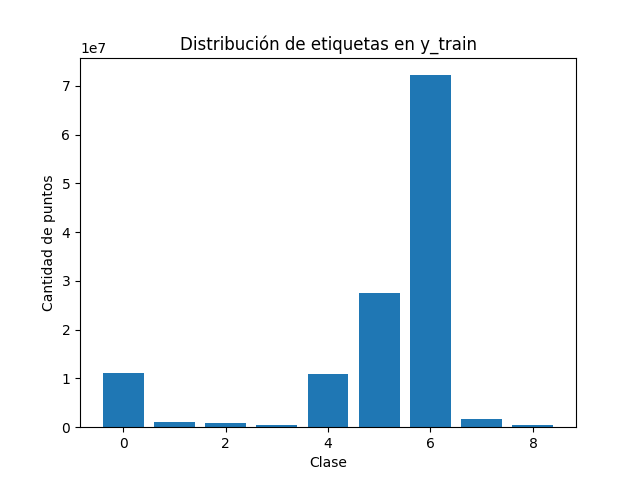

In [16]:
# Contar cuántos puntos hay por clase
unique_classes, class_counts = np.unique(y_train, return_counts=True)

print(len(y_train))

# Mostrar distribución de clases))
for cls, count in zip(unique_classes, class_counts):
    print(f"Clase {cls}: {count} puntos")

# Opcional: visualizar la distribución con un gráfico de barras
import matplotlib.pyplot as plt

plt.bar(unique_classes, class_counts)
plt.xlabel("Clase")
plt.ylabel("Cantidad de puntos")
plt.title("Distribución de etiquetas en y_train")
plt.show()

In [17]:
# Calcular pesos inversamente proporcionales a la frecuencia de cada clase
total_samples = len(y_train.flatten())  # Total de puntos
class_weights = {cls: total_samples / (len(unique_classes) * count) for cls, count in zip(unique_classes, class_counts)}

print("Pesos de las clases:", class_weights)

Pesos de las clases: {0: 1.271854384067209, 1: 13.571039457261849, 2: 16.835832387826102, 3: 26.256214015760193, 4: 1.2809707317431878, 5: 0.5089107726632501, 6: 0.1946185769864797, 7: 8.353065146170604, 8: 25.663616694609523}


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K

def tnet(inputs, num_features):
    """
    Implementación de T-Net para aprender transformaciones afines.
    """
    x = layers.Conv1D(64, 1, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(1024, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Matriz de transformación (num_features x num_features)
    x = layers.Dense(num_features * num_features, kernel_initializer='zeros',
                     bias_initializer=tf.keras.initializers.Constant(tf.eye(num_features).numpy().flatten()))(x)
    transform_matrix = layers.Reshape((num_features, num_features))(x)

    # Aplicar la transformación correctamente
    def transform(inputs_and_matrix):
        inputs, matrix = inputs_and_matrix
        return tf.matmul(inputs, matrix)

    transformed_inputs = layers.Lambda(transform)([inputs, transform_matrix])

    return transformed_inputs  # Retorna los datos transformados


def build_pointnet(num_classes, input_dim=3, max_points=16384):
    inputs = tf.keras.Input(shape=(None, input_dim))  # Entrada: N puntos con D características

    # Aplicar T-Net en la entrada para corregir la orientación de los puntos
    x = tnet(inputs, input_dim)

    # MLP Layers
    x = layers.Conv1D(64, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(64, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Aplicar T-Net en características para mejorar representaciones intermedias
    x = tnet(x, 64)

    x = layers.Conv1D(1024, 1, activation='relu')(x)  # MLP variable (64, 256, 1024, 2048)
    x = layers.BatchNormalization()(x)

    # **Corrección en la manipulación de `global_features`**
    global_features = layers.GlobalMaxPooling1D()(x)  # (batch, 1024)
    global_features = layers.Lambda(lambda t: tf.expand_dims(t, axis=1))(global_features)  # (batch, 1, 1024)
    global_features = layers.Lambda(lambda t: tf.tile(t, [1, max_points, 1]))(global_features)  # (batch, 16384, 1024)

    print(f"Shape de x antes de concatenar: {x.shape}")  # (batch, 16384, 1024)
    print(f"Shape de global_features: {global_features.shape}")  # (batch, 16384, 1024)

    x = layers.concatenate([x, global_features], axis=-1)  # Ambos tienen (batch, 16384, 2048)

    # MLP final para clasificación
    x = layers.Conv1D(512, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(256, 1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    #x = layers.Dropout(0.3)(x)  # Regularización

    outputs = layers.Conv1D(num_classes, 1, activation='softmax')(x)  # Clasificación por punto

    return Model(inputs, outputs)

In [19]:
import tensorflow as tf

class MeanIoUWrapper(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name="mean_iou_wrapper", **kwargs):
        super(MeanIoUWrapper, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.metric = tf.keras.metrics.MeanIoU(num_classes=num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=-1)  # Convertir (batch, 16384, 9) -> (batch, 16384)
        self.metric.update_state(y_true, y_pred_labels)

    def result(self):
        return self.metric.result()

    def reset_state(self):
        self.metric.reset_state()

In [20]:
import tensorflow as tf

# Convertir los pesos a tensores
class_weight_tensor = tf.constant([class_weights[i] for i in range(len(unique_classes))], dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    """Aplica pesos de clases a la pérdida de entropía cruzada"""
    y_true = tf.cast(y_true, tf.int32)
    sample_weights = tf.gather(class_weight_tensor, y_true)  # Asigna el peso según la clase
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * sample_weights  # Escala la pérdida por el peso de la clase

In [22]:
INPUT_DIM = 3
NUM_CLASSES = 9

# Definir el modelo PointNet
model = build_pointnet(num_classes=NUM_CLASSES, input_dim=INPUT_DIM)

mean_iou_wrapper = MeanIoUWrapper(num_classes=NUM_CLASSES)

# Compilar el modelo
model.compile(
    optimizer = tf.optimizers.Adam(learning_rate=0.0003),  # Adam con weight decay
    loss=weighted_loss,
    metrics=["accuracy", mean_iou_wrapper]
)

Shape de x antes de concatenar: (None, None, 1024)
Shape de global_features: (None, 16384, 1024)


In [ ]:
history = model.fit(
    x_train_shuffle,  
    y_train_shuffle,  
    validation_data=(x_val_shuffle, y_val_shuffle), 
    epochs=30,
    batch_size = 16,
    verbose=1
)

Epoch 1/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 378s 782ms/step - accuracy: 0.1974 - loss: 2.0782 - mean_iou_wrapper: 0.0620 - val_accuracy: 0.2606 - val_loss: 2.3051 - val_mean_iou_wrapper: 0.0676
Epoch 2/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.2560 - loss: 1.8835 - mean_iou_wrapper: 0.0811 - val_accuracy: 0.2635 - val_loss: 2.0695 - val_mean_iou_wrapper: 0.0844
Epoch 3/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.2668 - loss: 1.8064 - mean_iou_wrapper: 0.0890 - val_accuracy: 0.2187 - val_loss: 2.0295 - val_mean_iou_wrapper: 0.0717
Epoch 4/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.3200 - loss: 1.7121 - mean_iou_wrapper: 0.1051 - val_accuracy: 0.3783 - val_loss: 1.8921 - val_mean_iou_wrapper: 0.1164
Epoch 5/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.3409 - loss: 1.6596 - mean_iou_wrapper: 0.1135 - val_accuracy: 0.3608 - val_loss: 1.9976 - val_mean_iou_wrapper: 0.1206
Epoch 6/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms

In [ ]:
# Guardar modelo completo en formato .keras (recomendado desde TensorFlow 2.6+)
modelo.save("mi_modelo.keras")

# Guardar modelo en formato .h5 (si necesitas compatibilidad con versiones más antiguas)
modelo.save("mi_modelo.h5")

In [ ]:
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
import matplotlib.pyplot as plt

# Extraer métricas
loss = history.history['loss']
val_loss = history.history.get('val_loss')
mean_iou = history.history.get('mean_iou_wrapper')
val_mean_iou = history.history.get('val_mean_iou_wrapper')

# Crear figura
plt.figure(figsize=(12, 5))

# Gráfico de la pérdida
plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Gráfico de Mean IoU
if mean_iou:
    plt.subplot(1, 2, 2)
    plt.plot(mean_iou, label='Train Mean IoU')
    if val_mean_iou:
        plt.plot(val_mean_iou, label='Validation Mean IoU')
    plt.xlabel('Epochs')
    plt.ylabel('Mean IoU')
    plt.legend()
    plt.title('Mean IoU Curve')

plt.show()

Epoch 1/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 378s 782ms/step - accuracy: 0.1974 - loss: 2.0782 - mean_iou_wrapper: 0.0620 - val_accuracy: 0.2606 - val_loss: 2.3051 - val_mean_iou_wrapper: 0.0676
Epoch 2/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.2560 - loss: 1.8835 - mean_iou_wrapper: 0.0811 - val_accuracy: 0.2635 - val_loss: 2.0695 - val_mean_iou_wrapper: 0.0844
Epoch 3/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.2668 - loss: 1.8064 - mean_iou_wrapper: 0.0890 - val_accuracy: 0.2187 - val_loss: 2.0295 - val_mean_iou_wrapper: 0.0717
Epoch 4/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.3200 - loss: 1.7121 - mean_iou_wrapper: 0.1051 - val_accuracy: 0.3783 - val_loss: 1.8921 - val_mean_iou_wrapper: 0.1164
Epoch 5/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.3409 - loss: 1.6596 - mean_iou_wrapper: 0.1135 - val_accuracy: 0.3608 - val_loss: 1.9976 - val_mean_iou_wrapper: 0.1206
Epoch 6/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.3473 - loss: 1.6475 - mean_iou_wrapper: 0.1180 - val_accuracy: 0.2971 - val_loss: 1.8919 - val_mean_iou_wrapper: 0.0930
Epoch 7/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.3850 - loss: 1.5954 - mean_iou_wrapper: 0.1280 - val_accuracy: 0.3707 - val_loss: 2.1627 - val_mean_iou_wrapper: 0.1101
Epoch 8/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.3928 - loss: 1.5726 - mean_iou_wrapper: 0.1305 - val_accuracy: 0.3419 - val_loss: 1.8835 - val_mean_iou_wrapper: 0.1155
Epoch 9/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.4121 - loss: 1.5251 - mean_iou_wrapper: 0.1386 - val_accuracy: 0.3426 - val_loss: 2.0606 - val_mean_iou_wrapper: 0.1069
Epoch 10/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.4367 - loss: 1.4814 - mean_iou_wrapper: 0.1481 - val_accuracy: 0.4342 - val_loss: 1.9583 - val_mean_iou_wrapper: 0.1401
Epoch 11/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.4149 - loss: 1.5287 - mean_iou_wrapper: 0.1395 - val_accuracy: 0.3544 - val_loss: 1.8760 - val_mean_iou_wrapper: 0.1184
Epoch 12/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.4392 - loss: 1.4580 - mean_iou_wrapper: 0.1505 - val_accuracy: 0.3511 - val_loss: 1.7919 - val_mean_iou_wrapper: 0.1244
Epoch 13/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 723ms/step - accuracy: 0.4695 - loss: 1.3695 - mean_iou_wrapper: 0.1660 - val_accuracy: 0.4573 - val_loss: 1.6821 - val_mean_iou_wrapper: 0.1545
Epoch 14/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 722ms/step - accuracy: 0.4931 - loss: 1.3009 - mean_iou_wrapper: 0.1798 - val_accuracy: 0.5514 - val_loss: 1.6161 - val_mean_iou_wrapper: 0.1899
Epoch 15/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 722ms/step - accuracy: 0.5151 - loss: 1.2271 - mean_iou_wrapper: 0.2020 - val_accuracy: 0.6254 - val_loss: 1.8242 - val_mean_iou_wrapper: 0.2169
Epoch 16/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 722ms/step - accuracy: 0.5359 - loss: 1.1652 - mean_iou_wrapper: 0.2154 - val_accuracy: 0.5977 - val_loss: 1.6061 - val_mean_iou_wrapper: 0.2147
Epoch 17/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 722ms/step - accuracy: 0.5537 - loss: 1.1096 - mean_iou_wrapper: 0.2278 - val_accuracy: 0.6259 - val_loss: 2.0443 - val_mean_iou_wrapper: 0.1971
Epoch 18/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 349s 722ms/step - accuracy: 0.5662 - loss: 1.0688 - mean_iou_wrapper: 0.2377 - val_accuracy: 0.5784 - val_loss: 1.8561 - val_mean_iou_wrapper: 0.1962
Epoch 19/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 348s 721ms/step - accuracy: 0.5646 - loss: 1.0748 - mean_iou_wrapper: 0.2309 - val_accuracy: 0.5857 - val_loss: 1.7395 - val_mean_iou_wrapper: 0.2128
Epoch 20/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 348s 721ms/step - accuracy: 0.5844 - loss: 1.0161 - mean_iou_wrapper: 0.2496 - val_accuracy: 0.4979 - val_loss: 2.0896 - val_mean_iou_wrapper: 0.1632
Epoch 21/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 348s 721ms/step - accuracy: 0.6055 - loss: 0.9643 - mean_iou_wrapper: 0.2653 - val_accuracy: 0.5984 - val_loss: 1.8471 - val_mean_iou_wrapper: 0.2134
Epoch 22/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 348s 721ms/step - accuracy: 0.6205 - loss: 0.9233 - mean_iou_wrapper: 0.2813 - val_accuracy: 0.5607 - val_loss: 1.6588 - val_mean_iou_wrapper: 0.2047
Epoch 23/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 348s 721ms/step - accuracy: 0.6275 - loss: 0.8986 - mean_iou_wrapper: 0.2861 - val_accuracy: 0.5962 - val_loss: 1.7949 - val_mean_iou_wrapper: 0.2071
Epoch 24/30
483/483 ━━━━━━━━━━━━━━━━━━━━ 348s 721ms/step - accuracy: 0.6379 - loss: 0.8737 - mean_iou_wrapper: 0.2948 - val_accuracy: 0.1219 - val_loss: 52.6255 - val_mean_iou_wrapper: 0.0459
Epoch 25/30
204/483 ━━━━━━━━━━━━━━━━━━━━ 3:17 707ms/step - accuracy: 0.6255 - loss: 0.8810 - mean_iou_wrapper: 0.2887